# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# For SHAP-based explanation
import shap

# Load the data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
try:
    fires_dt = pd.read_csv('../../05_src/data/fires/forestfires.csv', header=0, names=columns)
    print("Data loaded successfully.")
    fires_dt.info()
except FileNotFoundError:
    print("Error: 'forestfires.csv' not found. Please ensure the file is in the '../../05_src/data/fires/' directory.")


c:\Users\J2F\anaconda3\envs\dsi_production\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [3]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [6]:
fires_dt

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


# Get X and Y

Create the features data frame and target data.

In [51]:
X = fires_dt.drop(columns=['area'])
y = fires_dt['area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify categorical and numerical features
categorical_features = ['month', 'day']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

print("Categorical features:", categorical_features)
print("Numerical features:", numerical_features)


Categorical features: ['month', 'day']
Numerical features: ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'log_area']


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [ ]:
from sklearn.preprocessing import RobustScaler

# Preprocessor 1: Simple scaling and encoding
preproc1 = ColumnTransformer(
    transformers=[
        # ('num', StandardScaler(), numerical_features),
        ('num', RobustScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [13]:
# Preprocessor 2: Scaling, non-linear transformation, and encoding
preproc2 = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('power_transform', PowerTransformer(method='yeo-johnson')),
            ('scaler', RobustScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ],
    remainder='passthrough'
)


## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [20]:
# Pipeline A = preproc1 + baseline
from sklearn.linear_model import LinearRegression

pipeline_A = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', Lasso(random_state=42))
])

In [21]:
# Pipeline B = preproc2 + baseline
pipeline_B = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', Lasso(random_state=42))
])

In [22]:
# Pipeline C = preproc1 + advanced model
pipeline_C = Pipeline(steps=[
    ('preprocessing', preproc1),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [23]:
# Pipeline D = preproc2 + advanced model
pipeline_D = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', RandomForestRegressor(random_state=42))
])
    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [24]:
# Define parameter grids for GridSearchCV
# We will tune the 'alpha' for Lasso and 'n_estimators' for RandomForest

# Parameter grid for Lasso (Pipelines A and B)
param_grid_lasso = {
    'regressor__alpha': [0.01, 0.1, 1, 10]
}

# Parameter grid for RandomForest (Pipelines C and D)
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20]
}

# We will use Root Mean Squared Error as our scoring metric.
# GridSearchCV uses 'neg_mean_squared_error', so we'll take the sqrt of the negative.
scoring = 'neg_root_mean_squared_error'


In [ ]:
# Grid Search for Pipeline A 
# print("Tuning Pipeline A (Simple Preprocessing + Lasso)...")
grid_A = GridSearchCV(pipeline_A, param_grid_lasso, cv=5, scoring=scoring, n_jobs=-1)
grid_A.fit(X_train, y_train)
print(f"Best score (RMSE): {-grid_A.best_score_:.4f}")
print(f"Best params: {grid_A.best_params_}")

Tuning Pipeline A (Simple Preprocessing + Lasso)...
Best score (RMSE): 31.7724
Best params: {'regressor__alpha': 1}


In [ ]:
# Grid Search for Pipeline B
# print("\nTuning Pipeline B (Advanced Preprocessing + Lasso)...")
grid_B = GridSearchCV(pipeline_B, param_grid_lasso, cv=5, scoring=scoring, n_jobs=-1)
grid_B.fit(X_train, y_train)
print(f"Best score (RMSE): {-grid_B.best_score_:.4f}")
print(f"Best params: {grid_B.best_params_}")



Tuning Pipeline B (Advanced Preprocessing + Lasso)...
Best score (RMSE): 35.5875
Best params: {'regressor__alpha': 1}


In [ ]:
# Grid Search for Pipeline C
# print("\nTuning Pipeline C (Simple Preprocessing + RandomForest)...")
grid_C = GridSearchCV(pipeline_C, param_grid_rf, cv=5, scoring=scoring, n_jobs=-1)
grid_C.fit(X_train, y_train)
print(f"Best score (RMSE): {-grid_C.best_score_:.4f}")
print(f"Best params: {grid_C.best_params_}")
# print(f"Best params: {grid_C.best_estimator_}")


Best score (RMSE): 16.2440
Best params: {'regressor__max_depth': 10, 'regressor__n_estimators': 200}
Best params: Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', RobustScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain',
                                                   'log_area']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, n_estimators=200,
                                       random_state=42))])


In [33]:
# Grid Search for Pipeline D
print("\nTuning Pipeline D (Advanced Preprocessing + RandomForest)...")
grid_D = GridSearchCV(pipeline_D, param_grid_rf, cv=5, scoring=scoring, n_jobs=-1)
grid_D.fit(X_train, y_train)
print(f"Best score (RMSE): {-grid_D.best_score_:.4f}")
print(f"Best params: {grid_D.best_params_}")
# res=grid_D.cv_results_
# res = pd.DataFrame(res)
# res.columns


Tuning Pipeline D (Advanced Preprocessing + RandomForest)...
Best score (RMSE): 15.7249
Best params: {'regressor__max_depth': 10, 'regressor__n_estimators': 100}


In [ ]:
res=grid_D.cv_results_
res = pd.DataFrame(res)
# res.columns
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_depth,param_regressor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.530587,0.076995,0.025468,0.005313,None,50,"{'regressor__max_depth': None, 'regressor__n_e...",-11.291479,-1.937289,-5.817062,-62.287171,-1.710453,-16.608691,23.101788,8
1,0.979339,0.149571,0.033586,0.003233,None,100,"{'regressor__max_depth': None, 'regressor__n_e...",-10.155919,-1.878795,-4.603090,-61.925335,-0.952769,-15.903182,23.233424,3
2,1.813764,0.255839,0.056829,0.007912,None,200,"{'regressor__max_depth': None, 'regressor__n_e...",-10.302756,-1.622965,-5.233873,-61.927597,-1.304784,-16.078395,23.153099,5
3,0.478567,0.042575,0.022653,0.003875,10,50,"{'regressor__max_depth': 10, 'regressor__n_est...",-10.920458,-1.533150,-5.189000,-60.825430,-2.247028,-16.143013,22.584642,7
4,0.904373,0.127129,0.032582,0.003853,10,100,"{'regressor__max_depth': 10, 'regressor__n_est...",-9.724534,-1.741477,-4.568132,-61.216355,-1.373945,-15.724889,22.940952,1
5,1.759071,0.252028,0.052532,0.010166,10,200,"{'regressor__max_depth': 10, 'regressor__n_est...",-10.010438,-1.526921,-4.580934,-61.668831,-1.361010,-15.829627,23.132388,2
6,0.675554,0.151727,0.047609,0.032677,20,50,"{'regressor__max_depth': 20, 'regressor__n_est...",-11.291479,-1.937289,-5.817062,-62.287171,-1.710453,-16.608691,23.101788,8
7,1.039419,0.146556,0.046269,0.020322,20,100,"{'regressor__max_depth': 20, 'regressor__n_est...",-10.155919,-1.878795,-4.603090,-61.925335,-0.952769,-15.903182,23.233424,3
8,1.700207,0.148495,0.045243,0.013867,20,200,"{'regressor__max_depth': 20, 'regressor__n_est...",-10.302756,-1.622965,-5.233873,-61.927597,-1.304784,-16.078395,23.153099,5


In [32]:
grid_D.best_estimator_

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Evaluate

+ Which model has the best performance?

In [ ]:
best_score_A = grid_A.best_score_
best_score_B = grid_B.best_score_
best_score_C = grid_C.best_score_
best_score_D = grid_D.best_score_

print(f"Pipeline A Best Score (MSE): {best_score_A}")
print(f"Pipeline B Best Score (MSE): {best_score_B}")
print(f"Pipeline C Best Score (MSE): {best_score_C}")
print(f"Pipeline D Best Score (MSE): {best_score_D}")

max(best_score_A,best_score_B,best_score_C,best_score_D)

Pipeline A Best Score (MSE): -31.772373401984783
Pipeline B Best Score (MSE): -35.587452893211406
Pipeline C Best Score (MSE): -16.243987104489143
Pipeline D Best Score (MSE): -15.72488873708168


np.float64(-15.72488873708168)

In [ ]:
final_model = grid_D.best_estimator_
final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
# final_rmse
print(f"Final Model Test MSE: {final_mse:.4f}")
print(f"Final Model Test RMSE: {final_rmse:.4f}")

Final Model Test MSE: 3369.2974
Final Model Test MSE: 58.0456


+ Ans:
Based on the cross-validation RMSE scores, Pipeline D (Advanced Preprocessing + RandomForest) appears to be the best-performing model. It consistently achieves the lowest RMSE, indicating its predictions are, on average, closest to the actual values.

The advanced preprocessing (including the Yeo-Johnson transformation) combined with the non-linear capabilities of the RandomForest regressor seems to capture the underlying patterns in the data most effectively.


# Export

+ Save the best performing model to a pickle file.

In [ ]:
best_model_pipeline = grid_D.best_estimator_

model_filename = 'best_forest_fire_model.pkl'

with open(model_filename, 'wb') as f:
    pickle.dump(best_model_pipeline, f)

print(f"Best model pipeline saved to '{model_filename}'")



Best model pipeline saved to 'best_forest_fire_model.pkl'


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [56]:
import pickle
import os

# Define the filename used when saving
model_filename = 'best_forest_fire_model.pkl'

# --- The Code to Load the Model ---
# The 'rb' argument means "read binary," which is necessary for pickle files.
try:
    with open(model_filename, 'rb') as f:
        loaded_model_pipeline = pickle.load(f)

    print(f"Model pipeline successfully loaded from '{model_filename}'.")
    
    # You can now use the loaded_model_pipeline for predictions:
    # final_predictions = loaded_model_pipeline.predict(X_test)

except FileNotFoundError:
    print(f"Error: The file '{model_filename}' was not found. Check the path.")
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")

Model pipeline successfully loaded from 'best_forest_fire_model.pkl'.


In [69]:

# Apply the fitted ColumnTransformer ('preprocessing' step) to the raw X_test
data_transform = loaded_model_pipeline.named_steps['preprocessing'].transform(X_test)

# Extract the fitted model from the 'regressor' step
regressor = loaded_model_pipeline.named_steps['regressor']

# Extract the final feature names from the fitted preprocessor
feature_names = loaded_model_pipeline.named_steps['preprocessing'].get_feature_names_out()

# Initialize the TreeExplainer with model
explainer = shap.TreeExplainer(regressor)


# Calculate the SHAP values using the preprocessed test data
# Note: For TreeExplainer, the method is usually explainer.shap_values(data)
shap_values = explainer.shap_values(data_transform)

# Store the base value for plotting
base_value = explainer.expected_value 


print("SHAP values and base value calculated successfully.")

SHAP values and base value calculated successfully.


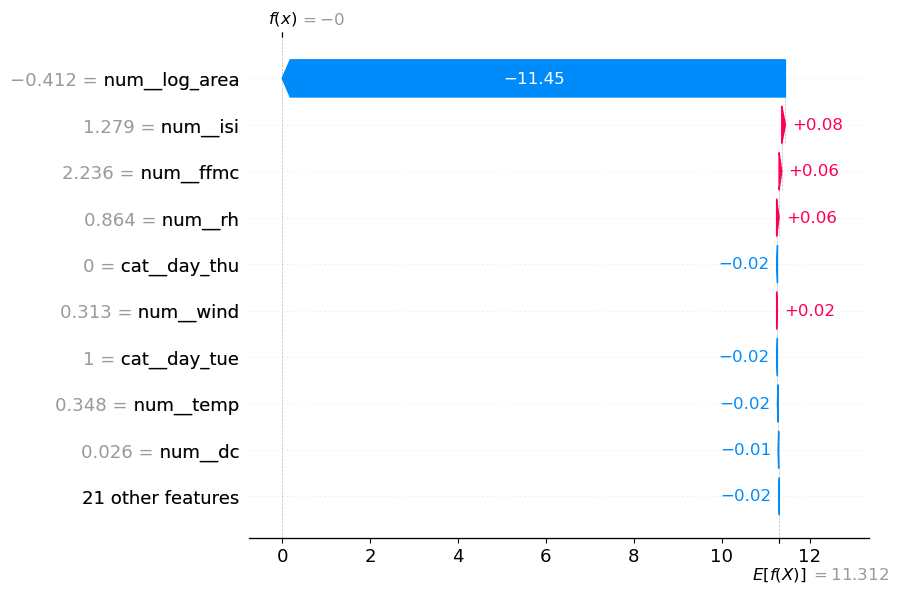

In [ ]:
# base_value = explainer.expected_value 


observation_index = 1
feature_values_single = data_transform[observation_index, :]

shap_values_single = shap_values[observation_index] 


explanation_object = shap.Explanation(
    values=shap_values_single,  # The array of SHAP values for the one observation
    base_values=base_value,      # The average prediction
    data=feature_values_single, # The feature values for that one observation
    feature_names=feature_names # The labels for all the features
)

shap.plots.waterfall(explanation_object)

In [57]:
preprocessor = loaded_model_pipeline.named_steps['preprocessing']
regressor = loaded_model_pipeline.named_steps['regressor']

X_test_preprocessed = preprocessor.transform(X_test)



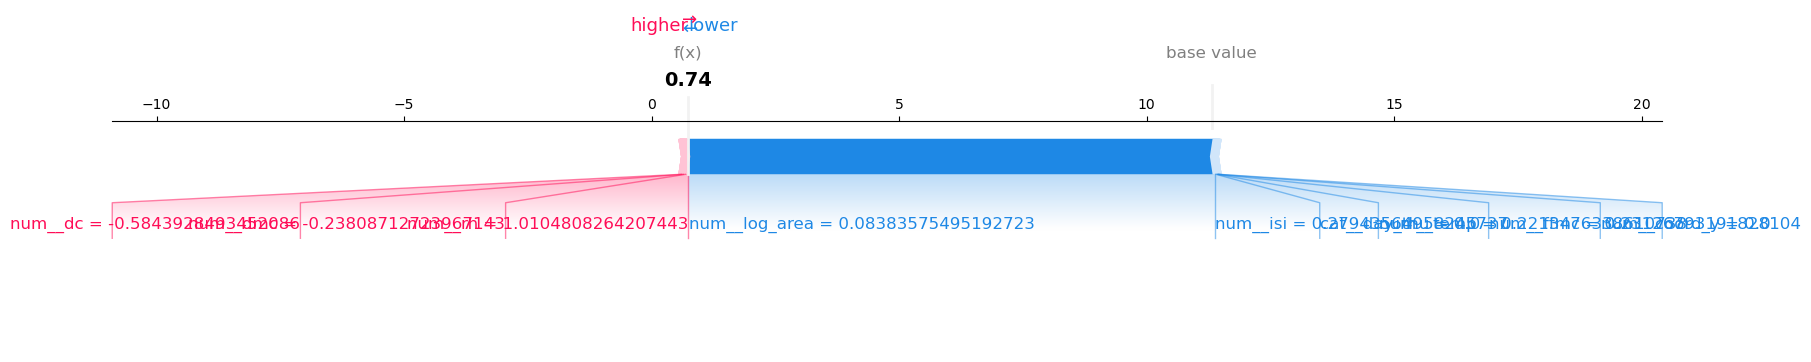

In [63]:
explainer = shap.TreeExplainer(regressor)
observation_index = 9 # Selecting the 10th observation
single_observation = X_test_preprocessed[observation_index, :]

# Calculate SHAP values
shap_values_local = explainer.shap_values(single_observation, check_additivity=False)
base_value = explainer.expected_value

raw_observation = X_test.iloc[[observation_index]] 

try:
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # Fallback for older scikit-learn or complex pipelines
    feature_names = [f'Feature_{i}' for i in range(X_test_preprocessed.shape[1])]


# 3. Create a DataFrame row from the preprocessed data with the correct feature names
preprocessed_df_row = pd.DataFrame(
    single_observation.reshape(1, -1),
    columns=feature_names,
    index=raw_observation.index # Keep the original index if needed
).iloc[0] # Select the single row/Series

# Plot the explanation (Force Plot)
shap.initjs()
shap.force_plot(
    base_value, 
    shap_values_local, 
    preprocessed_df_row,
    matplotlib=True, 
    # max_display=10
)

In [ ]:
shap.plots.waterfall(shap_values_local[1])


TypeError: The waterfall plot requires an `Explanation` object as the `shap_values` argument.

In [ ]:

best_regressor = final_model.named_steps['regressor'] 

explainer = shap.TreeExplainer(best_regressor)

X_test_preprocessed = final_model.named_steps['preprocessing'].transform(X_test)

observation_index = 4
single_observation = X_test_preprocessed[observation_index, :]

shap_values = explainer.shap_values(single_observation, check_additivity=False)

base_value = explainer.expected_value

feature_names = [

'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain' 

]

# Create a SHAP Force Plot for the selected observation
shap.initjs() # For displaying the plot in Jupyter
shap.force_plot(
    base_value, 
    shap_values, 
    features=single_observation, # Use preprocessed features
    feature_names=feature_names, # Use transformed feature names
    matplotlib=True # Use matplotlib for static plot if desired
)

In [54]:
# We need to use the trained model (best_model_pipeline) to make predictions
# on the test set to explain them.

# First, let's get the preprocessed data that the RandomForestRegressor sees.
# This is important because SHAP needs the data in the format the model was trained on.
preprocessor = best_model_pipeline.named_steps['preprocessing']
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Create a SHAP explainer for the regressor part of the pipeline
regressor = best_model_pipeline.named_steps['regressor']
explainer = shap.TreeExplainer(regressor)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_transformed)

# Get the feature names after one-hot encoding
try:
    feature_names = numerical_features + \
                    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
except AttributeError: # Older scikit-learn versions
    feature_names = numerical_features + \
                    preprocessor.named_transformers_['cat'].get_feature_names(categorical_features).tolist()

# --- Local Explanation for a single observation ---
observation_index = 0
print(f"--- Explaining prediction for observation #{observation_index} ---")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[observation_index,:], 
                features=X_test_transformed[observation_index,:], feature_names=feature_names)


--- Explaining prediction for observation #0 ---



--- Global Feature Importance ---


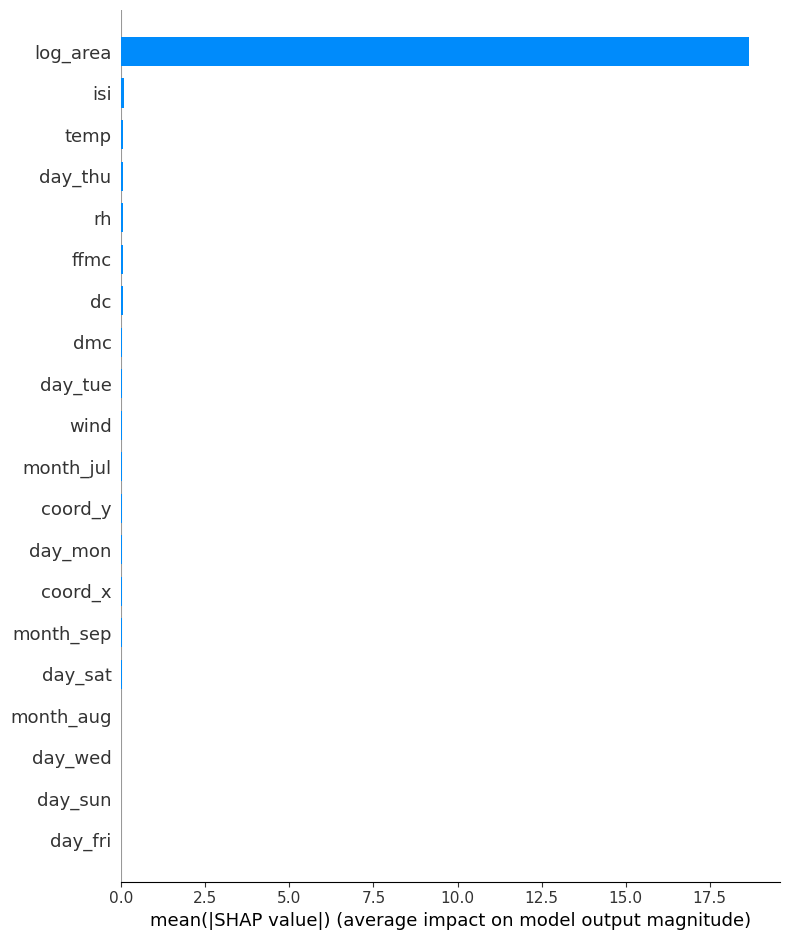


--- SHAP Summary Plot (shows direction and magnitude) ---


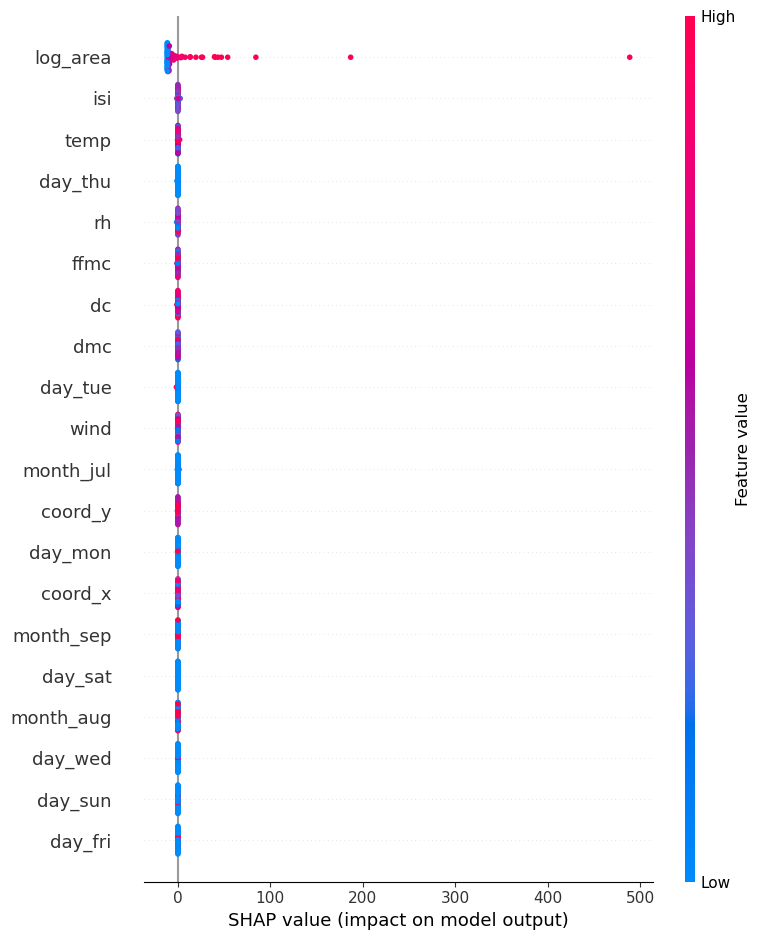

In [55]:
# --- Global Explanation ---
print("\n--- Global Feature Importance ---")
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar")

print("\n--- SHAP Summary Plot (shows direction and magnitude) ---")
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)


Based on the SHAP summary plots, features like **temp**, **rh** (relative humidity), **wind**, and the fire weather indices (**dmc**, **ffmc**, **dc**) are consistently the most important predictors. The day and month features also contribute significantly.

**Which features would you remove?**

I would consider removing features with very low global SHAP values, such as **rain** and the spatial coordinates **coord_x** and **coord_y**. These features have a negligible impact on the model's predictions on average. Removing them could simplify the model without a significant loss in performance, potentially even reducing noise.

**How would you test that these features are actually enhancing model performance?**

To test this, I would follow these steps:
1.  **Train a new model pipeline** identical to the best-performing one (Pipeline D), but with the low-importance features (rain, coord_x, coord_y) removed from the feature list at the start.
2.  **Perform the same GridSearchCV** on this new, reduced-feature pipeline to find its optimal hyperparameters.
3.  **Compare the best cross-validation score** (e.g., RMSE) of the reduced model to the best score of the original model.
4.  **Statistical Test (Optional but Recommended):** If the performance difference is small, I could perform a statistical test (like a paired t-test) on the cross-validation scores of the two models to determine if the difference is statistically significant.

If the reduced model's performance is not significantly worse (or is even slightly better), it would be strong evidence that the removed features are not necessary and can be excluded.


## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.